In [4]:
# Install required libraries
!pip install torch torchvision einops matplotlib tqdm torchsummary

In [8]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.optim as optim
from tqdm import tqdm
from torch import nn
from einops import rearrange
import matplotlib.pyplot as plt
import os
import matplotlib.pyplot as plt
from torchsummary import summary
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
import numpy as np
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

In [6]:
def get_transforms():
    return transforms.Compose([
        transforms.ToTensor(),
    ])

def get_mnist_dataloader(train=True):
    dataset = datasets.MNIST(
        root="./data", train=train, download=True, transform=get_transforms()
    )
    dataloader = DataLoader(dataset, batch_size=Config.BATCH_SIZE, shuffle=train)
    return dataloader

In [4]:
class Encoder(nn.Module):
    def __init__(self, latent_dim, image_size):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1),  # 16 x 14 x 14
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),  # 32 x 7 x 7
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(32 * 7 * 7, latent_dim),
        )

    def forward(self, x):
        return self.net(x)

class Decoder(nn.Module):
    def __init__(self, latent_dim, image_size):
        super().__init__()
        self.linear = nn.Linear(latent_dim, 32 * 7 * 7)
        self.upconv = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 4, stride=2, padding=1),  # 16 x 14 x 14
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 4, stride=2, padding=1),  # 1 x 28 x 28
            nn.Sigmoid(),
        )

    def forward(self, z):
        x = self.linear(z)
        x = rearrange(x, "b (c h w) -> b c h w", c=32, h=7, w=7)
        return self.upconv(x)

class Autoencoder(nn.Module):
    def __init__(self, latent_dim=64, image_size=28):
        super().__init__()
        self.encoder = Encoder(latent_dim, image_size)
        self.decoder = Decoder(latent_dim, image_size)

    def encode(self, x):
        return self.encoder(x)

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)


In [5]:
def train_autoencoder():
    # Load data
    train_loader = get_mnist_dataloader(train=True)

    # Initialize model, loss, and optimizer
    autoencoder = Autoencoder(latent_dim=Config.LATENT_DIM, image_size=Config.IMAGE_SIZE).to(Config.DEVICE)
    summary(autoencoder, input_size=(1, Config.IMAGE_SIZE, Config.IMAGE_SIZE))
    criterion = nn.MSELoss()
    optimizer = optim.Adam(autoencoder.parameters(), lr=Config.LR)

    loss_history = []
    # Training loop
    autoencoder.train()
    for epoch in range(Config.EPOCHS):
        epoch_loss = 0
        pbar = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{Config.EPOCHS}")
        for images, _ in pbar:
            images = images.to(Config.DEVICE)

            # Forward pass
            recon_images = autoencoder(images)
            loss = criterion(recon_images, images)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Track loss
            epoch_loss += loss.item()
            pbar.set_postfix({"Loss": f"{loss.item():.4f}"})

        average_loss = epoch_loss / len(train_loader)
        loss_history.append(average_loss)
        print(f"Epoch {epoch + 1}: Average Loss: {average_loss:.4f}")

    # Save the trained model
    torch.save(autoencoder.state_dict(), "autoencoder.pth")
    print("Autoencoder training completed and model saved.")

    # Plot the loss curve
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, Config.EPOCHS + 1), loss_history, marker='o', label='Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss Curve')
    plt.legend()
    plt.grid(True)
    plt.show()


In [7]:
def train_model(model, dataloader):
    optimizer = torch.optim.Adam(model.parameters(), lr=Config.LR)
    for epoch in range(Config.EPOCHS):
        for images, _ in dataloader:
            images = images.to(Config.DEVICE)
            loss = model.training_step(images)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        print(f"Epoch {epoch + 1}/{Config.EPOCHS}, Loss: {loss.item()}")


In [10]:
class Config:
    DATASET_NAME = "MNIST"
    IMAGE_SIZE = 28
    LATENT_DIM = 64

    BATCH_SIZE = 64
    EPOCHS = 10
    LR = 1e-4
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [14]:
train_autoencoder()


Epoch 1/10:  37%|███▋      | 343/938 [00:04<00:07, 75.62it/s, Loss=0.0660]


KeyboardInterrupt: 

In [ ]:
def calculate_metrics(original, reconstructed):
    original = original.cpu().numpy()
    reconstructed = reconstructed.cpu().numpy()
    ssim_scores = []
    psnr_scores = []

    for i in range(original.shape[0]):
        original_img = original[i, 0]
        reconstructed_img = reconstructed[i, 0]

        ssim_score = ssim(original_img, reconstructed_img, data_range=original_img.max() - original_img.min())
        psnr_score = psnr(original_img, reconstructed_img, data_range=original_img.max() - original_img.min())

        ssim_scores.append(ssim_score)
        psnr_scores.append(psnr_score)

    return np.mean(ssim_scores), np.mean(psnr_scores)

In [6]:
def visualize_reconstructions():
    # Load the model
    autoencoder = Autoencoder(latent_dim=Config.LATENT_DIM, image_size=Config.IMAGE_SIZE).to(Config.DEVICE)
    autoencoder.load_state_dict(torch.load("autoencoder.pth"))
    autoencoder.eval()

    # Get test data
    test_loader = get_mnist_dataloader(train=False)
    images, _ = next(iter(test_loader))
    images = images.to(Config.DEVICE)

    # Reconstruct
    with torch.no_grad():
        recon_images = autoencoder(images)

    # Calculate metrics
    avg_ssim, avg_psnr = calculate_metrics(images, recon_images)
    print(f"Average SSIM: {avg_ssim:.4f}, Average PSNR: {avg_psnr:.2f}")

    # Visualize
    plt.figure(figsize=(12, 6))
    for i in range(10):
        # Original
        plt.subplot(2, 10, i + 1)
        plt.imshow(images[i][0].cpu().numpy(), cmap="gray")
        plt.axis("off")

        # Reconstructed
        plt.subplot(2, 10, i + 11)
        plt.imshow(recon_images[i][0].cpu().numpy(), cmap="gray")
        plt.axis("off")
    plt.suptitle(f"SSIM: {avg_ssim:.4f}, PSNR: {avg_psnr:.2f}")
    plt.show()


<ipython-input-6-8729effbdb78>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  autoencoder.load_state_dict(torch.load("autoencoder.pth"))


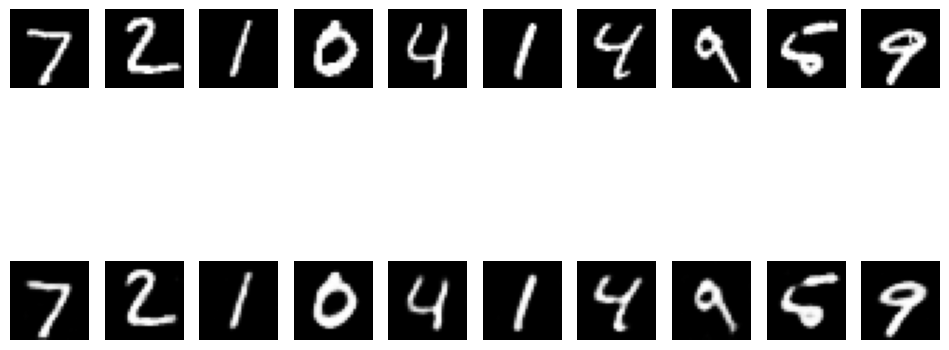

In [15]:
visualize_reconstructions()


In [ ]:


def visualize_latent_space():
    autoencoder = Autoencoder(latent_dim=Config.LATENT_DIM, image_size=Config.IMAGE_SIZE).to(Config.DEVICE)
    autoencoder.load_state_dict(torch.load("autoencoder.pth"))
    autoencoder.eval()

    test_loader = get_mnist_dataloader(train=False)
    images, labels = next(iter(test_loader))
    images = images.to(Config.DEVICE)

    with torch.no_grad():
        latents = autoencoder.encode(images).cpu().numpy()

    # Use PCA or t-SNE for visualization
    tsne = TSNE(n_components=2, random_state=42)
    latents_2d = tsne.fit_transform(latents)

    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(latents_2d[:, 0], latents_2d[:, 1], c=labels, cmap="tab10", s=10)
    plt.colorbar(scatter, label="Digit Label")
    plt.title("Latent Space Visualization")
    plt.xlabel("Dimension 1")
    plt.ylabel("Dimension 2")
    plt.show()
